#  Прогнозирования количества заказов такси на следующий час.

**Описание данных:**

**Признаки**
- `datetime` — Дата и время

**Целевой признак**
- `num_orders` — Количество заказов такси

**Этапы работы**

1. [Подготовка данных](#Подготовка)
2. [Анализ данных](#Анализ)
3. [Обучение моделей](#Обучение)
4. [Тестирование модели](#Тестирование)

**Цель:**

Разработка модели прогнозирования количества заказов такси на следующий час на основе исторических данных компании "Чётенькое такси". Основная задача - предсказание пиковой нагрузки на такси для оптимизации работы водителей и улучшения обслуживания клиентов. Метрика успешности модели - значение RMSE на тестовой выборке, которое не должно превышать 48.

In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from itertools import product

from statsmodels.tsa.arima.model import ARIMA

from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import warnings

warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 17
tss = TimeSeriesSplit(n_splits=5)

In [3]:
def build_hist_box_plot(df, col, xlabel, title):
    """
    Строит гистограмму и бокс-плот для анализа распределения числовой переменной.

    Параметры:
    - df: DataFrame, содержащий данные.
    - col: Название столбца, для которого строится гистограмма и бокс-плот.
    - xlabel: Подпись оси x.
    - title: Название графика.

    Пример:
    ```
    build_hist_box_plot(data, 'age', 'Возраст', 'Распределение возраста в компании')
    ```

    """
    plt.figure(figsize=(13, 7))
    
    
    plt.subplot(1, 2, 1)
    sns.histplot(x=df[col], kde=False, bins=30)
    plt.xlabel(xlabel)
    
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.ylabel('')
    plt.xlabel(xlabel)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    display(df[col].describe())
    

    
    
def make_features(data, max_lag, rolling_mean_size):
    """
    Добавляет новые признаки к DataFrame для анализа временных данных.

    Параметры:
    - data: DataFrame, содержащий временные данные.
    - max_lag: Максимальная задержка (lag) для создания отстающих признаков.
    - rolling_mean_size: Размер окна скользящего среднего для создания признака скользящего среднего.

    Результат:
    - Исходный DataFrame с добавленными признаками:
        - 'month': Месяц из индекса.
        - 'day': День месяца из индекса.
        - 'hour': Час из индекса.
        - 'dayofweek': День недели из индекса.
        - 'lag_{lag}': Отстающий признак для количества заказов с задержкой в {lag} временных единиц.
        - 'rolling_mean': Скользящее среднее для количества заказов.

    Пример вызова:
    ```
    make_features(data, 7, 1)
    ```

    """
    improved_data = data.copy()
    improved_data['day'] = improved_data.index.day
    improved_data['hour'] = improved_data.index.hour
    improved_data['dayofweek'] = improved_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        improved_data['lag_{}'.format(lag)] = improved_data['num_orders'].shift(lag)

    improved_data['rolling_mean'] = improved_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return improved_data

## Подготовка

### Загрузка данных

In [4]:
pth1 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
else:
    print('There is no such file')
    
taxi.sort_index(inplace=True)

In [5]:
display(taxi.sample(5))
taxi.info()

,num_orders
datetime,
2018-08-03 18:30:00,19
2018-05-08 08:40:00,15
2018-05-12 14:20:00,18
2018-08-15 15:40:00,18
2018-03-20 17:00:00,15


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные успешно загружены, пропущенных значений не обнаружено.

### Ресемплирование

In [6]:
taxi = taxi.resample('1H').sum()
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплирование выполнено успешно.

## Анализ

### Временной промежуток исследования

In [7]:
print("Минимальная дата:", taxi.index.min())
print("Максимальная дата:", taxi.index.max())

Минимальная дата: 2018-03-01 00:00:00
Максимальная дата: 2018-08-31 23:00:00


У нас имеются наблюдения с 1 марта по 31 августа 2018 года.

### Графики

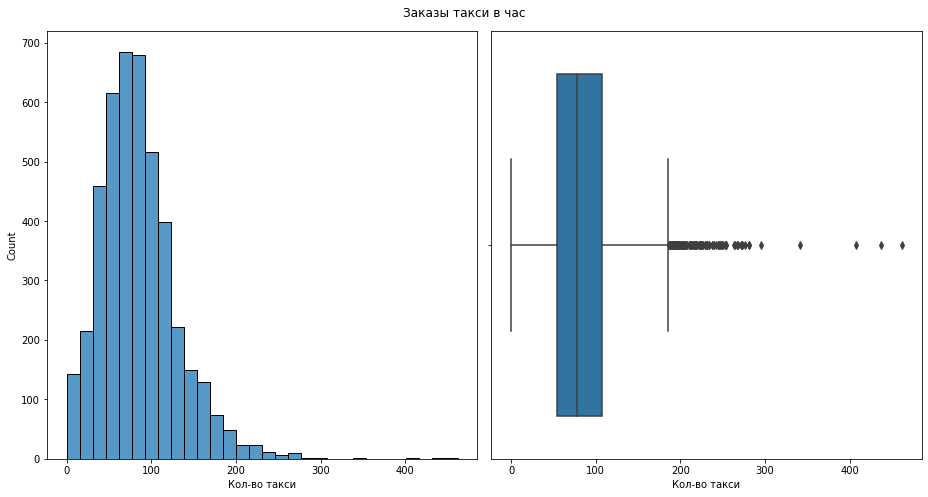

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [8]:
build_hist_box_plot(taxi, 'num_orders','Кол-во такси', 'Заказы такси в час')

Минимальное количество заказов такси в час составляет 0, максимальное количество - 462, с медианным значением 78.

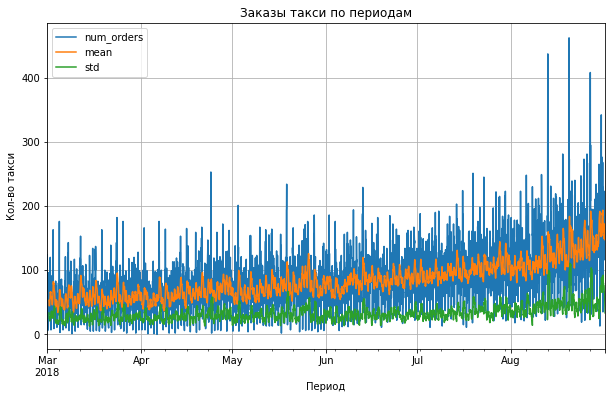

In [9]:
taxi['mean'] = taxi['num_orders'].shift().rolling(15).mean()
taxi['std'] = taxi['num_orders'].shift().rolling(15).std()
fig, ax = plt.subplots(figsize=(10, 6)) 
taxi.plot(ax=ax)
ax.set_title('Заказы такси по периодам')
ax.set_xlabel('Период')
ax.set_ylabel('Кол-во такси')
ax.grid(True)
plt.show()
taxi = taxi.drop(['mean', 'std'], axis = 1)

По графику мы можем сделать вывод, что это нестационарный временной ряд, поскольку со временем меняются как среднее, так и стандартное отклонение. На протяжении всего наблюдаемого периода наблюдается рост среднего количества заказов такси в час от 10 до почти 30. Также наблюдается увеличение стандартного отклонения.

Проведем тест Дики — Фуллера
- H_0: Ряд является нестационарным

- H_1: Ряд является стационарным

In [10]:
result = adfuller(taxi['num_orders'])
p_value = result[1]

print("p-значение:", p_value)
print()
alpha = 0.01
print(f'Для alpha: {alpha}')
if p_value < alpha:
    print("Отвергаем нулевую гипотезу, ряд стационарен")
else:
    print("Не отвергаем нулевую гипотезу, ряд нестационарен")
print()
alpha = 0.05
print(f'Для alpha: {alpha}')
if p_value < alpha:
    print("Отвергаем нулевую гипотезу, ряд стационарен")
else:
    print("Не отвергаем нулевую гипотезу, ряд нестационарен")    

p-значение: 0.028940051402612906

Для alpha: 0.01
Не отвергаем нулевую гипотезу, ряд нестационарен

Для alpha: 0.05
Отвергаем нулевую гипотезу, ряд стационарен


При уровне значимости 1% ряд является нестационарным, а при уровне значимости 5% стационарным, это может означать, что у нас есть некоторые признаки стационарности, но они не настолько сильные, чтобы считать ряд стационарным при более высоком уровне значимости.

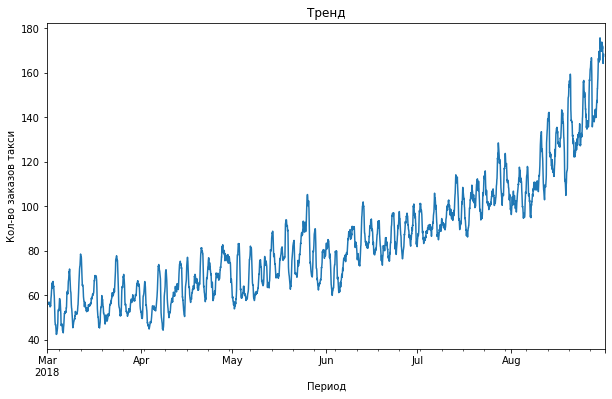

In [11]:
decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(10,6))
decomposed.trend.plot()
plt.xlabel('Период')
plt.ylabel('Кол-во заказов такси')
plt.title('Тренд');

Наши предыдущие слова подтверждаются и графиком тренда. Мы можем наблюдать, что трендовая линия растет и достигает своего пика в конце августа. Можно предположить, что это связано с возвращением людей с отпусков.

Кроме того, следует отметить, что график сезонности за все время не выдаст ценной информации, так как у нас имеются данные за период менее одного года.

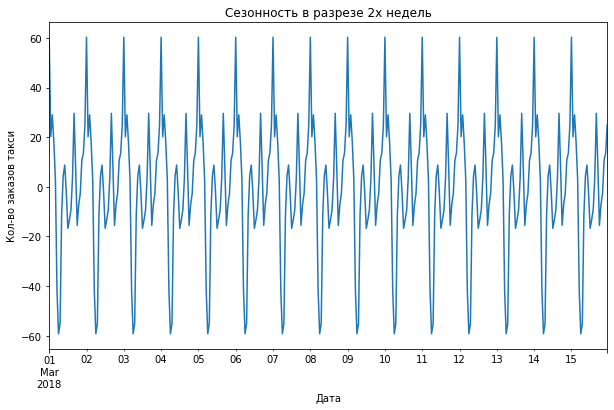

In [12]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())

plt.xlabel('Дата')

plt.title('Сезонность в разрезе 2х недель')
plt.ylabel('Кол-во заказов такси')
plt.show()

По графику сезонности за две недели видно, что основные колебания происходят в течение дня. Изучим информацию в течение дня более подробно.

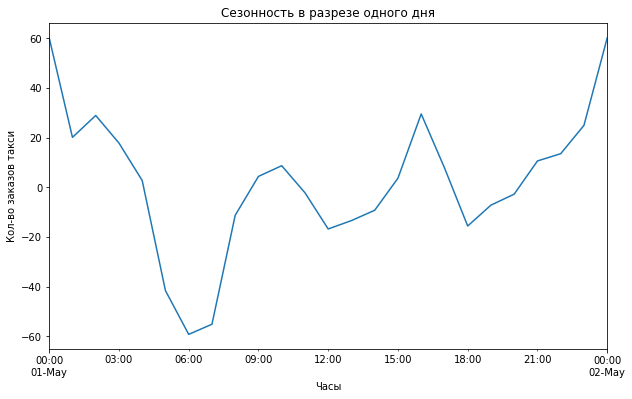

In [13]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-05-01':'2018-05-02 00:00:00'].plot(ax=plt.gca())

plt.xlabel('Часы')

plt.title('Сезонность в разрезе одного дня')
plt.ylabel('Кол-во заказов такси')
plt.show()

По графику видно, что пик заказов такси приходится на ночное время суток, а основной спад наблюдается в 6 утра. Вероятно, это связано с тем, что даже те, кто может рассчитывать на встречу со стороны родственников или друзкй, в определенные часы не в состоянии воспользоваться этой возможностью и вынуждены прибегнуть к заказу такси.

**Вывод:**
- Наблюдения проводились с 1 марта по 31 августа 2018 года.
- Минимальное количество заказов такси в час составляло 0, максимальное - 462, медианное - 78.
- График показывает нестационарный временной ряд, с изменениями как в среднем, так и в стандартном отклонении.
- Среднее количество заказов увеличивается со временем, достигая пика в конце августа, вероятно, связанного с возвращением людей с отпусков.
- График сезонности за две недели показывает, что основные колебания происходят в течение дня, с пиком заказов в ночное время и спадом в 6 утра, что, вероятно, связано с ограничениями возможностей получить помощь от родственников или друзей.

## Обучение

### Создание признаков

In [14]:
taxi_featured = make_features(taxi, 168, 24)
taxi_featured.head(5)

,num_orders,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Деление на выборки

In [15]:
train, test = train_test_split(taxi_featured, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

### Подбор модели

**LinearRegression**

In [16]:
model_lr = LinearRegression()

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model_lr) 
])

param_grid_lr = {
     'scaler': [StandardScaler(), RobustScaler(), None]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_lr.fit(features_train, target_train)

best_pipeline_lr = grid_search_lr.best_estimator_
target_predict_train = best_pipeline_lr.predict(features_train)
rmse_score_lr = grid_search_lr.best_score_ * -1
training_time_lr = grid_search_lr.refit_time_

print("Время обучения LinearRegression:", training_time_lr)
print("RMSE LinearRegression:", rmse_score_lr)
print("Лучшая модель:")
print(best_pipeline_lr)

Время обучения LinearRegression: 0.30522680282592773
RMSE LinearRegression: 22.54896747652147
Лучшая модель:
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])


**DecisionTreeRegressor**

In [17]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model_dt) 
])

param_grid_dt = {
    'scaler': [StandardScaler(), RobustScaler(), None],
    'regressor__max_depth': [5, 10, 15]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_dt.fit(features_train, target_train)

best_pipeline_dt = grid_search_dt.best_estimator_
target_predict_train = best_pipeline_dt.predict(features_train)
rmse_score_dt = grid_search_dt.best_score_ * -1
training_time_dt = grid_search_dt.refit_time_

print("Время обучения DecisionTreeRegressor:", training_time_dt)
print("RMSE DecisionTreeRegressor:", rmse_score_dt)
print("Лучшая модель DecisionTreeRegressor:")
print(best_pipeline_dt)

Время обучения DecisionTreeRegressor: 0.18384075164794922
RMSE DecisionTreeRegressor: 27.601654857465537
Лучшая модель DecisionTreeRegressor:
Pipeline(steps=[('scaler', None),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, random_state=17))])


**LGBMRegressor**

In [18]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model_lgbm)
])

param_grid_lgbm = {
    'scaler': [StandardScaler(with_mean=False), None],
    'regressor__num_leaves': [50, 100] 
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_lgbm.fit(features_train, target_train)


best_pipeline_lgbm = grid_search_lgbm.best_estimator_ 
target_predict_train_lgbm = best_pipeline_lgbm.predict(features_train)
rmse_score_lgbm = grid_search_lgbm.best_score_ * -1
training_time_lgbm = grid_search_lgbm.refit_time_

print("Время обучения LGBMRegressor:", training_time_lgbm)
print("RMSE LGBMRegressor:", rmse_score_lgbm)
print("Лучшая модель LGBMRegressor:")
print(best_pipeline_lgbm)

Время обучения LGBMRegressor: 15.500266790390015
RMSE LGBMRegressor: 23.12003652889625
Лучшая модель LGBMRegressor:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('regressor', LGBMRegressor(num_leaves=100, random_state=17))])


**CatBoostRegressor**

In [19]:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

pipeline_catboost = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model_catboost)
])

param_grid_catboost = {
    'scaler': [StandardScaler(with_mean=False), None],
    'regressor__iterations': [100, 200], 
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__depth': [4, 6]
}

grid_search_catboost = GridSearchCV(pipeline_catboost, param_grid_catboost, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_catboost.fit(features_train, target_train)



best_pipeline_catboost = grid_search_catboost.best_estimator_
target_predict_train_catboost = best_pipeline_catboost.predict(features_train)
rmse_score_catboost = grid_search_catboost.best_score_ * -1
training_time_catboost = grid_search_catboost.refit_time_

print("Время обучения CatBoostRegressor:", training_time_catboost)
print("RMSE CatBoostRegressor:", rmse_score_catboost)
print("Лучшая модель CatBoostRegressor:")
print(best_pipeline_catboost)

Время обучения CatBoostRegressor: 2.0913965702056885
RMSE CatBoostRegressor: 22.511762659284717
Лучшая модель CatBoostRegressor:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7ff0f963f730>)])


**Arima**

In [20]:
train_a, test_a = train_test_split(taxi, shuffle=False, test_size=0.1)
model = ARIMA(train['num_orders'], order=(2, 1, 2))
rmse_list = []
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
training_time_arima = end_time - start_time


for train_index, test_index in tss.split(train_a):
    train_cv, test_cv = train_a.iloc[train_index], train_a.iloc[test_index]
    
    model_cv = ARIMA(train_cv['num_orders'], order=(2, 1, 2))
    model_cv_fit = model_cv.fit()
    
    predictions = model_cv_fit.forecast(steps=len(test_cv))

    rmse_list.append(np.sqrt(mean_squared_error(test_cv['num_orders'], predictions)))
rmse_score_arima = sum(rmse_list) / len(rmse_list)

print("Время обучения Arima:", training_time_arima)
print("RMSE Arima:", rmse_score_arima)

Время обучения Arima: 4.779909610748291
RMSE Arima: 35.984309086869644


### Анализ результатов

In [21]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'LGBMRegressor',
         'CatBoost',
         'Arima']

data = {'RMSE':[rmse_score_lr,
                rmse_score_dt,
                rmse_score_lgbm,
                rmse_score_catboost,
                rmse_score_arima],
        
        'Время обучения модели':[training_time_lr,
                                 training_time_dt,
                                 training_time_lgbm,
                                 training_time_catboost,
                                 training_time_arima]
       }
model_rating = pd.DataFrame(data=data, index=index)
model_rating.sort_values(by=['RMSE'])

,RMSE,Время обучения модели
CatBoost,22.511763,2.091397
LinearRegression,22.548967,0.305227
LGBMRegressor,23.120037,15.500267
DecisionTreeRegressor,27.601655,0.183841
Arima,35.984309,4.779910


**Вывод:**

Обучив 5 моделей машинного обучения, можно сделать вывод, что модель CatBoost демонстрирует наилучшее качество по метрике RMSE, достигшее 22.51. Стоит отметить, что время обучения этой модели составляет 2 секунд, что не является лучшим показателем среди рассмотренных моделей. Однако, учитывая, что время обучения не является критическим фактором для заказчика, рекомендуется выбрать модель CatBoost для дальнейшего использования, поскольку она обеспечивает наилучшее качество прогнозирования.

## Тестирование

### Проверка лучшей модели на тестовых данных

In [22]:
target_predict_test_catboost = best_pipeline_catboost.predict(features_test)
rmse_test_catboost = mean_squared_error(target_test, target_predict_test_catboost, squared=False)

print("RMSE на тестовой выборке для CatBoost:", rmse_test_catboost)

RMSE на тестовой выборке для CatBoost: 38.02186144757253


Мы успешно удовлетворили требование заказчика (RMSE < 48).

### Сравнение предсказаний модели с реальными значениями

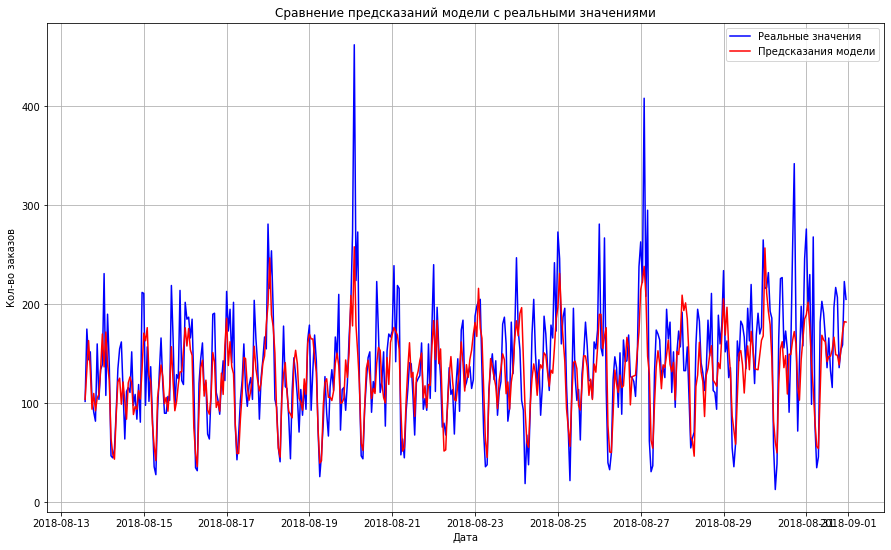

In [23]:
pivot = pd.DataFrame(target_test)
pivot['pred'] = target_predict_test_catboost
plt.figure(figsize=(15, 9))
plt.plot(pivot['num_orders'], label='Реальные значения', color='blue')
plt.plot(pivot['pred'], label='Предсказания модели', color='red')
plt.title('Сравнение предсказаний модели с реальными значениями')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.grid(True)
plt.show()

Можно отметить, что модели наиболее затруднительно предсказывать экстремально высокие значения. Вероятно, это обусловлено ограниченным количеством таких случаев в обучающих данных.

### Сравнение лучшей модели с DummyRegressor

In [24]:
model_dummy = DummyRegressor(strategy="mean")

model_dummy.fit(features_train, target_train)

target_predict_train_dummy = model_dummy.predict(features_train)

target_predict_test_dummy = model_dummy.predict(features_test)
rmse_test_dummy = mean_squared_error(target_test, target_predict_test_dummy, squared=False)
print("RMSE на тестовой выборке для DummyRegressor :", rmse_test_dummy)

RMSE на тестовой выборке для DummyRegressor : 83.97941361168559


Кроме того, наша модель превосходит дамми-регрессор, что свидетельствует о ее качественной работе. Этот результат подчеркивает эффективность и точность нашей модели в сравнении с простыми базовыми методами предсказания.

## Вывод

- Мы успешно загрузили и ресемплировали данные, а также провели исследовательский анализ. После обучения и оценки моделей регрессии мы выяснили, что наилучшую производительность продемонстрировала модель градиентного бустинга CatBoostRegressor. На тренировочных данных значение метрики RMSE составило 22.51, а на тестовых данных - 38.02. Эти результаты удовлетворяют требования заказчика.

- Также мы сравнили нашу модель с дамми-регрессором, и наша модель превзошла дамми-регрессор, что подтверждает ее высокое качество.

- Лучшая модель сохранена в переменной `best_pipeline_catboost`.